In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
# from transformers import AutoImageProcessor, ResNetForImageClassification,ResNetConfig
import torch
from abc import ABC,abstractmethod

In [3]:
#TODO check if layers are actually being trained
#TODO add more models
#TODO compare metrics
#TODO test out prediction loop
#TODO learn how to use tensorboard

#TODO week2 Balance Dataset
#TODO day2 Implement checkpointing and checkpoint loading
#TODO day2 implement an actually good and modular pipeline
#TODO day2 EDA + explore augments
#TODO day2 normalize and test out mean/median/std of pixel values
#TODO day2 Actually implement additional layers and finish what i started
#TODO Verify data is sent correctly (esp labels)

#TODO day2 implement localization/segmentation + research more abt osteopenia
#interesting models: yolo v5, medsam

###DATASET PREP###

In [2]:
projectPath = r"Osteoporosis Knee X-ray"
pathList = []
labelList = []
dirList = os.listdir(projectPath)[:3]
for idx, x in enumerate(dirList):
    for xx in os.listdir(f"{projectPath}/{x}"):
        pathList.append(f"{projectPath}/{x}/{xx}")
        labelList.append(idx)

In [3]:
from PIL import Image
imageSizes = {}
for x in pathList:
    img = Image.open(x).size
    try:
        imageSizes[str(img)] = imageSizes[str(img)] + 1
    except KeyError:
        imageSizes[str(img)] = 1
imageSizes #varied image sizes, have to resize to 1024,1024

{'(1024, 1024)': 63,
 '(2180, 2660)': 61,
 '(2660, 2180)': 10,
 '(2430, 1994)': 94,
 '(2386, 1994)': 1,
 '(1994, 2430)': 2,
 '(2430, 1910)': 2,
 '(2402, 1994)': 1,
 '(2378, 1994)': 2,
 '(2362, 1994)': 1,
 '(2430, 1958)': 1,
 '(2398, 1994)': 1}

In [17]:
import torchvision
image = Image.open(pathList[0]).convert('RGB')
image = torchvision.transforms.functional.pil_to_tensor(image)

image.sum(dim=[1,2])

ValueError: conversion from RGB to grayscale not supported

In [4]:
import torchvision
import torch
import torchvision.transforms.functional


class OsteoTorchDataset(torch.utils.data.Dataset):
    def __init__(self, itemsPath:list, labels:list, transform=None, std = False, mean = False): #mean on if mean needs to be scaled, same goes for std
        
        self.itemsPath = itemsPath
        self.labels = labels
        self.transform = transform
        self.std = std
        self.mean = mean

    def __len__(self):
        return len(self.itemsPath)

    def __getitem__(self,idx)->tuple[Image.Image,int]:
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        image = Image.open(self.itemsPath[idx]).convert('RGB')
        # image = torchvision.transforms.functional.pil_to_tensor(image)

        if self.transform:
            image = self.transform(image)  
        
        image.to(device = torch.device('cuda'))

        if self.mean or self.std:
            image = self.scaler(image,self.mean,self.std)
        

        return image, self.labels[idx], self.itemsPath[idx]          
    
    def scaler(self,image:torch.tensor,normMean = False,normStd = False): #TODO better way to do this? also huge bottleneck without cuda
        imageSum = torch.sum(image,dim=(1,2))
        mean = imageSum/(image.shape[1]*image.shape[2])
        sum_squared_tensor = torch.sum((imageSum - mean)**2)
        std = torch.sqrt(sum_squared_tensor/image.shape[1]*image.shape[2])

        if not normMean:
            mean = torch.zeros_like(mean,device='cuda')

        if not normStd:
            std = torch.ones_like(std,device='cuda')

        image = torchvision.transforms.functional.normalize(image.float(),mean,std)
        return image
        


transform = torchvision.transforms.Compose([
                                            torchvision.transforms.Resize([244,244]),
                                            torchvision.transforms.ToTensor()
                                            # ,torchvision.transforms.Grayscale()
                                            ])
osteoDataset = OsteoTorchDataset(pathList,labelList,transform,std=True,mean=True)                                  
temp = next(iter(osteoDataset))

In [201]:
temp[0].max()
image = Image.open(temp[2]).convert('RGB')
image = torchvision.transforms.functional.pil_to_tensor(image)
print(image.max())

tensor(248, dtype=torch.uint8)


In [23]:
from torch.utils.data import DataLoader

import torchvision.transforms as transforms

# Define the transform to convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create a DataLoader with the image dataset
data_loader = DataLoader(osteoDataset, batch_size=1, shuffle=False)

# Initialize variables for accumulating sum and sum of squares
sum_tensor = torch.zeros(3)
sum_squared_tensor = torch.zeros(3)

imageSizes = {}
# Iterate over the dataset and calculate the sum and sum of squares
for image, _, _ in data_loader:
    sum_tensor += torch.sum(image, dim=(0, 2, 3))
    sum_squared_tensor += torch.sum(image ** 2, dim=(0, 2, 3))
    try: 
        imageSizes[str(image.shape)] = imageSizes[str(image.shape)] + 1
    except KeyError:
        imageSizes[str(image.shape)] = 1


# Calculate the mean and standard deviation
num_samples = len(osteoDataset)
mean_tensor = sum_tensor / (num_samples * 244 * 244)
std_tensor = torch.sqrt((sum_squared_tensor / (num_samples * 244 * 244)))   
 
# Convert the mean and standard deviation tensors to numpy arrays
mean = mean_tensor.numpy()
std = std_tensor.numpy()

# Print the mean and standard deviation
print("Mean:", mean)
print("Standard Deviation:", std)

Mean: [1.7068879e-11 1.7068820e-11 1.7068976e-11]
Standard Deviation: [3.053201e-07 3.053201e-07 3.053201e-07]


In [5]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import WeightedRandomSampler

osteoDataset = OsteoTorchDataset(pathList,labelList,transform,std=False,mean=False)      
train,val = torch.utils.data.random_split(osteoDataset,[0.8,0.2])#MAY BUG
trainLabels = [y for x,y,z in train]
unique_elements, counts = torch.unique(torch.tensor(trainLabels), return_counts=True)
sampleWeights = 1. / counts.float() #I HAVE NO IDEA WHY THIS WORKS BUT IT DOES
# MORAL OF THE STORY: FOLLOW THE FUCKING TUTORIAL DONT TRY CHANGING SHIT ON YOUR OWN ***EVEN IF THE DOCUMENTATION SAYS YOU SHOULD***
trainSampler = WeightedRandomSampler(weights=[sampleWeights[x] for x in trainLabels],num_samples=len(train),replacement=True)

trainLoader = DataLoader(train, batch_size = 32,shuffle=False,num_workers=0,sampler=trainSampler)
valLoader = DataLoader(val, batch_size = len(val),shuffle=False,num_workers=0)

unique_elements, counts = torch.unique(torch.cat([x for y,x,z in trainLoader]), return_counts=True)#delet this
counts

tensor([65, 64, 63])

In [6]:
temp = next(iter(trainLoader))
print(temp[0].min(),temp[0].max())

tensor(0.) tensor(1.)


tensor(0) Osteoporosis Knee X-ray/normal/N25.jpg
torch.Size([3, 244, 244])


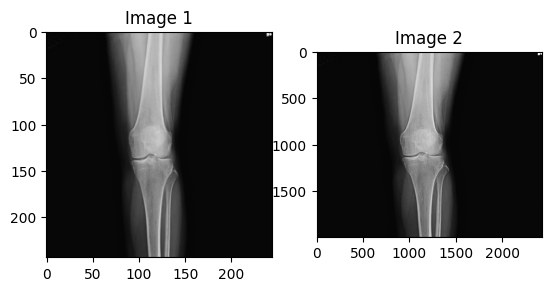

In [169]:
# temp[0][0].min()
index += 1
print(temp[1][index],temp[2][index])
print(temp[0][index].shape)

fig, axs = plt.subplots(1, 2)

# Plot the first image
axs[0].imshow(temp[0][index].permute(1, 2, 0))
axs[0].set_title('Image 1')

# Plot the second image
axs[1].imshow(Image.open(temp[2][index]).convert('RGB'))
axs[1].set_title('Image 2')

plt.show()

In [187]:
imageSum

tensor([201511269, 201511269, 201511269])

In [189]:
import matplotlib.pyplot as plt
image = temp[2][0]
image = Image.open(image).convert('RGB')
image = torchvision.transforms.functional.pil_to_tensor(image)
image = torchvision.transforms.functional.to_tensor(image)
# imageSum = torch.sum(image,dim=(1,2))
# mean = imageSum/(image.shape[1]*image.shape[2])
# sum_squared_tensor = imageSum**2 -(2*imageSum*mean) + mean**2
# std = torch.sqrt(sum_squared_tensor/image.shape[1]*image.shape[2])

# image = torchvision.transforms.functional.normalize(image.float(),mean,std)
# plt.imshow(image.permute(1, 2, 0))
image

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

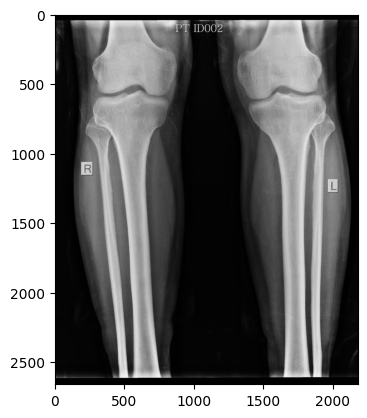

In [99]:
image = temp[2][0]
image = Image.open(image).convert('RGB')
image = torchvision.transforms.functional.pil_to_tensor(image)
imageSum = torch.sum(image,dim=(1,2))
mean = imageSum/(image.shape[1]*image.shape[2])

plt.imshow(image.permute(1, 2, 0))

# import seaborn as sns
# sns.histplot(image[0].flatten())

In [7]:
# import models here
from models import AlexNet,resnetWrapper
from resnetModel import ResNet50
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from torcheval.metrics.functional import multiclass_f1_score,multiclass_confusion_matrix,multiclass_accuracy
from torchmetrics.classification import MulticlassConfusionMatrix
from matplotlib import pyplot as plt
from torch import mode
import torch.nn.functional as F
import itertools
import seaborn as sns

#FIXME identify bottleneck
#FIXME clean up my fucking code ffs its so UGLY

class ExperimentAlexNet(L.LightningModule):

    existingModels = []

    def __init__(self,pretrainedModel,resize = False) -> None:
        ExperimentAlexNet.existingModels.append(self)
        super().__init__()
        self.model = pretrainedModel

        self.resize = resize
        if self.resize:
            self.linear1 = torch.nn.Linear(1000,256)
            self.relu1= torch.nn.ReLU()
            self.linear2 = torch.nn.Linear(256,3)

        self.valLog = []
        self.epoch = []
        self.valPreds = []
        self.valLabels = []
        self.valScore = []

        self.bestValPreds = [[]]
        self.bestValLabels = [[]]
        self.bestValScore = []

        self.dump = []
        
    def forward(self,input):
        out = self.model(input)
        if self.resize:
            out = self.linear1(out)
            out = self.linear2(out)
        return out
        
    def training_step(self,batch):
        data,label,path = batch

        output = self(data.float())
        # print('\n train pred vs label')
        # print(output.argmax(1))
        print(output.argmax(1))
        print(label)
        self.dump.append([path,label])
        loss = F.cross_entropy(output,label)
        # print(loss)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx) -> None:
        data,label,path = batch
        output = self(data.float())

        preds = output.argmax(1)
        f1 = multiclass_f1_score(preds,label,num_classes=3,average = 'macro')
        # print('\npred vs label')
        # print(preds)
        # print(label)
        # print(f'f1:{f1}')
        loss = F.cross_entropy(output,label)
        self.valLabels.append(label)
        self.valPreds.append(output)
        self.valScore.append(multiclass_f1_score(preds,label,num_classes=3,average = 'macro'))
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_F1", multiclass_f1_score(preds,label,num_classes=3,average = 'macro'), on_step=False, on_epoch=True, prog_bar=True, logger=True,)
        self.log("val_acc", multiclass_accuracy(preds,label,num_classes=3), on_step=False, on_epoch=True, prog_bar=True, logger=True)

    
    def on_validation_epoch_end(self) -> None:
        if len(self.valScore) == 2:
            return None
        
        accuracy = torch.stack(self.valScore).mean()
        self.bestValScore.append(accuracy)
        self.bestValPreds.append(torch.cat(self.valPreds))
        self.bestValLabels.append(torch.cat(self.valLabels))

        # print(f"\n Validation accuracy: {accuracy}")
        # print(f"bestValScore: {self.bestValScore}")
        
        self.valPreds = []
        self.valLabels = []
        self.valScore = []
        

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(),lr=0.001)

    def predict_step(self, batch):
        data,label = batch
        return self(data.float())

# class ResNetCallbacks(L.Callback): #TODO implement callbacks
#     def on_validation_epoch_end(trainer, pl_module):
#         valLog.append(sum(self.cumLog)/len(self.cumlog))

# alexNet = ExperimentAlexNet(AlexNet(num_classes=3))
# resNet = ExperimentAlexNet(ResNet50(num_classes=3))
preResNet = ExperimentAlexNet(resnetWrapper(),resize=True)

c:\Users\assaw\.conda\envs\AI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in C:\Users\assaw/.cache\torch\hub\pytorch_vision_v0.19.0
C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:

# # pred = torch.tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
# #         1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
lab = torch.tensor([1, 2, 1, 0, 2, 2, 0, 1, 0, 0, 0, 1, 1, 2, 2, 0, 2, 1, 1, 2, 1, 0, 0, 0,
        1, 0, 1, 1, 2, 0, 0, 0], device='cpu')
# lab = torch.tensor([[1,0,0]]*3, device='cpu',dtype = torch.float16)
yhat = torch.tensor([[-0.1028, -0.6118, -0.4407],
        [ 0.5879,  0.0624, -0.1104],
        [ 0.2615, -0.5229, -0.0128],
        [-0.1072, -0.5122,  0.0526],
        [-0.1277,  0.1517,  0.2327],
        [-0.4985, -0.1786,  0.0179],
        [ 0.0822, -0.2080, -0.0985],
        [ 0.5776,  0.1541,  0.1838],
        [ 0.0662,  0.5005,  0.8325],
        [ 0.2251, -0.1404, -0.1917],
        [ 0.8594,  0.3831,  0.4404],
        [ 0.0808,  0.1646, -0.4233],
        [-0.0845,  0.0886,  0.0777],
        [ 0.7676, -0.3047,  0.6333],
        [ 0.2231, -0.0163,  0.2788],
        [ 0.7676,  0.0701, -0.0076],
        [-0.0584, -0.0936,  0.4067],
        [ 0.5737,  0.1621,  0.2368],
        [ 0.5190, -0.6431,  0.3071],
        [-0.0600, -0.5342, -0.4553],
        [ 0.1676, -0.4670, -0.9048],
        [ 0.3071, -0.3948,  0.5889],
        [ 0.3796, -0.6206, -0.7437],
        [-0.2937, -0.3232, -1.3340],
        [ 0.5190, -0.6431,  0.3071],
        [ 0.3071, -0.3948,  0.5889],
        [ 0.1245, -0.0804, -0.3655],
        [ 0.5229, -0.1285, -0.3689],
        [ 0.8706,  0.3096, -0.3276],
        [ 0.0822, -0.2080, -0.0985],
        [ 0.8594,  0.3831,  0.4404],
        [-0.2937, -0.3232, -1.3340]], device='cpu', dtype=torch.float16)


F.cross_entropy(yhat,lab)

tensor(1.1221, dtype=torch.float16)

In [9]:
# import re
# labelProcess = [re.search(r'\/.*\/',x)[0] for x in preResNet.dump[0][0]]
# [x.strip('\/') for x in labelProcess]

In [10]:
import gc
gc.collect()
torch.cuda.empty_cache()

from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    verbose=False,        # Verbosity mode
    mode='min'           # Mode can be 'min', 'max', or 'auto'
)

logger = TensorBoardLogger("tb_logs", name="my_model")


trainer = L.Trainer(max_epochs = 50,accelerator='gpu', devices='auto', precision='16-mixed',callbacks=[early_stopping],logger=logger)
trainer.fit(model=preResNet,train_dataloaders=trainLoader,val_dataloaders=valLoader)


Using 16bit Automatic Mixed Precision (AMP)
c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | model   | ResNet | 25.6 M | train
1 | linear1 | Linear | 256 K  | train
2 | relu1   | ReLU   | 0      | train
3 | linear2 | Linea

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 47. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/6 [00:00<?, ?it/s] tensor([2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 2, 0, 1, 0,
        0, 0, 2, 1, 2, 2, 2, 1], device='cuda:0')
tensor([1, 1, 0, 0, 2, 0, 2, 0, 1, 2, 1, 0, 2, 1, 0, 2, 1, 2, 1, 2, 2, 0, 1, 2,
        0, 2, 2, 1, 0, 1, 0, 1], device='cuda:0')


c:\Users\assaw\.conda\envs\AI\lib\site-packages\lightning\pytorch\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0:  17%|█▋        | 1/6 [00:01<00:08,  0.58it/s, v_num=24, train_loss_step=1.070]tensor([0, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2,
        2, 0, 2, 1, 2, 0, 2, 0], device='cuda:0')
tensor([0, 0, 1, 0, 0, 0, 2, 1, 2, 1, 2, 1, 2, 0, 2, 2, 0, 0, 1, 0, 2, 0, 2, 2,
        2, 0, 0, 1, 2, 2, 1, 0], device='cuda:0')
Epoch 0:  33%|███▎      | 2/6 [00:03<00:06,  0.63it/s, v_num=24, train_loss_step=1.090]tensor([2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 0,
        0, 2, 1, 2, 2, 2, 0, 1], device='cuda:0')
tensor([1, 2, 2, 1, 0, 1, 1, 1, 2, 0, 2, 0, 1, 0, 2, 1, 2, 1, 0, 0, 1, 2, 0, 0,
        0, 0, 1, 2, 0, 2, 0, 2], device='cuda:0')
Epoch 0:  50%|█████     | 3/6 [00:04<00:04,  0.66it/s, v_num=24, train_loss_step=1.030]tensor([2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 0, 0, 2, 2, 1, 2, 1, 0, 2, 0, 2, 0, 1, 2,
        2, 2, 2, 2, 2, 2, 0, 0], device='cuda:0')
tensor([0, 1, 0, 0, 1, 2, 0, 1, 2, 1, 0, 0, 0, 2, 2, 0, 1, 2, 2, 0, 1, 2, 1, 0,
        2

In [11]:
trainer.fit(model=resNet,train_dataloaders=trainLoader,val_dataloaders=valLoader)

NameError: name 'resNet' is not defined

In [ ]:
# raise AssertionError("done")
x = preResNet
print(f"model: {x.model.__class__.__name__}")
print(f"bestValScore: {x.bestValScore}")
print(f"bestValPreds: {[[y.argmax().item() for y in w] for w in x.bestValPreds]}")
    # print(f"bestValLabels: {x.bestValLabels}")

model: ResNet
bestValScore: [tensor(0.2700, device='cuda:0'), tensor(0.4022, device='cuda:0'), tensor(0.3234, device='cuda:0'), tensor(0.3212, device='cuda:0'), tensor(0.3030, device='cuda:0'), tensor(0.3849, device='cuda:0'), tensor(0.3565, device='cuda:0'), tensor(0.2986, device='cuda:0'), tensor(0.4605, device='cuda:0'), tensor(0.4737, device='cuda:0'), tensor(0.6331, device='cuda:0'), tensor(0.3160, device='cuda:0'), tensor(0.5228, device='cuda:0'), tensor(0.5543, device='cuda:0'), tensor(0.5206, device='cuda:0'), tensor(0.3990, device='cuda:0'), tensor(0.5982, device='cuda:0'), tensor(0.4921, device='cuda:0'), tensor(0.4190, device='cuda:0'), tensor(0.5483, device='cuda:0'), tensor(0.4188, device='cuda:0'), tensor(0.4608, device='cuda:0'), tensor(0.4807, device='cuda:0'), tensor(0.4906, device='cuda:0'), tensor(0.4810, device='cuda:0'), tensor(0.5483, device='cuda:0'), tensor(0.5039, device='cuda:0'), tensor(0.4390, device='cuda:0'), tensor(0.4376, device='cuda:0'), tensor(0.4238,

In [ ]:
# [[y.argmax().item() for y in w] for w in x.bestValPreds]
# ([1, 2, 0, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 2, 1,
#          1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
[[y.argmax().item() for y in w] for w in x.bestValPreds]


[[],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  1,
  1],
 [0,
  0,
  0,
  1,
  2,
  1,
  1,
  2,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  2,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0],
 [0,
  0,
  1,
  1,
  2,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  0,
  2,
  0,
  1,
  0,
  2,
  0,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  2,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0],
 [0,
  0,
  1,
  1,
  2,
  1,
  1,
  2,
  1,
  0,
 

In [ ]:
for x in [[y.argmax().item() for y in w] for w in x.bestValPreds]:
    print(x)

[]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
evalPred = torch.tensor([[y.argmax().item() for y in w] for w in x.bestValPreds][2]).to('cuda:0')
evalPred

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')

In [ ]:
multiclass_f1_score(evalPred,evalLabels,num_classes=3,average='macro')

tensor(0.2980, device='cuda:0')

In [ ]:
import sklearn
sklearn.metrics.f1_score(evalLabels.cpu(),evalPred.cpu(),average='macro')

0.2980392156862745

In [ ]:
# raise AssertionError("Stop here")
# alex net acc F1 = 0.62 loss = 0.923
# resnet18 acc F1 = ? loss = 1
# resnet50 acc F1 = 0.29 loss = 3
# resnet50 Custom acc F1 = 0.62 loss = 0.957
# resnet50 Custom acc oversampled F1 = 0.78 loss = 0.759
# mobilenet 
# effnet
# Vits 

# model = alexNetNonMod.load_from_checkpoint("/path/to/checkpoint.ckpt")


def testConfMatrix(self) -> None:
        y_hat = torch.tensor([y.argmax() for y in self.bestValPreds]).to('cpu')
        y = self.bestValLabels.to('cpu')

        print(y_hat),print(y)

        confusion_matrix = MulticlassConfusionMatrix(num_classes=3,normalize='true')
        print(confusion_matrix(y_hat, y))

        confusion_matrix_computed = confusion_matrix.compute().detach().cpu().numpy()

        df_cm = pd.DataFrame(confusion_matrix_computed)
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral',fmt='g').get_figure()
        plt.show()
       

testConfMatrix(modelList[3])

# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Metric to monitor
#     patience=3,          # Number of epochs with no improvement after which training will be stopped
#     verbose=True,        # Verbosity mode
#     mode='min'           # Mode can be 'min', 'max', or 'auto'
# )

# logger = TensorBoardLogger("tb_logs", name="my_model")
# trainer = L.Trainer(max_epochs = 20,accelerator='gpu', devices='auto', precision='16-mixed',callbacks=[early_stopping],logger=logger)
# trainer.fit(model=alexNetNonMod,train_dataloaders=trainLoader,val_dataloaders=valLoader

In [ ]:
x

In [ ]:
data = []
label = []
valOutput = []
valLabel = []

from itertools import tee
testTrainer =  L.Trainer(accelerator='gpu', devices='auto')
out = testTrainer.predict(alexNet, valLoader)

loader1, loader2 = tee(valLoader) #BUG BUG BUG INCREDIBLY MEMORY INEFFICIENT DONOT RUN THIS ON ANYTHIGN BIGGER THAN 1000 IMAGES

for idx,x in enumerate(valLoader):
    data,label = x
    [valLabel.append(x) for x in label]

valOutput = trainer.predict(alexNet, loader2)

In [ ]:
label